In [228]:
CELL_TYPE = 'pDC'

In [229]:
import numpy as np
import seaborn as sns
from pyprojroot.here import here
import re
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from tqdm.auto import tqdm

# Import functions
sys.path.insert(1, str(here('bin')))
from customPythonFunctions import load_shap_statistics

### Fix file name || TO DELETE

In [230]:
def fix_file_names( cell_type: str = '',
                    run_name: str = 'run1',
                    dirpath: str = '',
                  ):

    import numpy as np
    import re
    from pyprojroot import here
    

    fname_regex = f'^fix_{run_name}_{cell_type}_shap_values_stats_' + r'(\d+)'

    results_batches = [
        (fname, int(re.search(fname_regex, fname).group(1)))
        for fname in os.listdir(dirpath)
        if re.search(fname_regex, fname)]
    
    largest_batch_fname = max(results_batches, key=lambda x: x[1])[0]

    shap_stats = np.load(os.path.join(dirpath, largest_batch_fname))

    target_path = os.path.join(dirpath, f'total_{run_name}_{cell_type}_shap_stats.npz')

    print(target_path, end='.. ')

    if os.path.exists(target_path):
        print('EXISTS!!!! Not saved u.u')
    else:
        np.savez(target_path, **shap_stats)
        print('Saved!')


In [231]:
fix_file_names(cell_type=CELL_TYPE, run_name='studyID', dirpath=here('03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/'))

/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/total_studyID_pDC_shap_stats.npz.. EXISTS!!!! Not saved u.u


## ^^^^^^^ TO DELETE ^^^^^^

#### Loading important genes per study

In [232]:
_, _, studyID_mean_abs, _ = load_shap_statistics(cell_type=CELL_TYPE, 
                                     interactions=False, 
                                     run_name='studyID',
                                     dirpath=here('03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/')
                                    )

#### Loading important genes per disease

In [233]:
_, _, disease_mean_abs, _ = load_shap_statistics(cell_type=CELL_TYPE, 
                                     interactions=False, 
                                     run_name='run1',
                                     dirpath=here('03_downstream_analysis/08_gene_importance/results/targetY_disease/shap/shap_vals/')
                                    )

#### Loading adata

In [234]:
symbol_df = pd.read_pickle(here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'))
symbol_df.head()

,hgnc_id,symbol,locus_group,HUGO_status
ensembl_gene_id,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein_coding,official
ENSG00000000457,HGNC:19285,SCYL3,protein_coding,official
ENSG00000000938,HGNC:3697,FGR,protein_coding,official
ENSG00000000971,HGNC:4883,CFH,protein_coding,official
ENSG00000001036,HGNC:4008,FUCA2,protein_coding,official


In [235]:

adata = ad.read_h5ad(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed = 'r')

adata.var = adata.var.merge(symbol_df, left_index=True, right_index=True, how='left')

genes = adata.var['symbol'].values
disease = adata.obs.disease.cat.categories
studyID = adata.obs.studyID.cat.categories


In [236]:
target_dis = 'BRCA'

In [237]:
from scipy.stats import spearmanr, pearsonr

disease_max_cor_dict = dict()

correlation_matrix = []

for target_dis in disease:
    corr_coef = []
    for i in range(total_study_genes.shape[1]):
    
        v1 = studyID_mean_abs[:,i]
        v2 = disease_mean_abs[:,disease == target_dis].flatten()
        
        corr_coef.append(pearsonr(v1, v2)[0])

    correlation_matrix.append(corr_coef)
    # disease_max_cor_dict[target_dis] = max(corr_coef)
    
        # print(studyID[i])
        
        # plt.scatter(x = v1, y = v2)
        # plt.xlabel('studyID')
        # plt.ylabel('disease')
        # plt.show()

correlation_matrix = np.array(correlation_matrix)


In [238]:
correlation_matrix.shape

(20, 16)

In [239]:
import marsilea as ma
import marsilea.plotter as mp

In [240]:
diseaseXstudy = adata.obs[['studyID','disease']].drop_duplicates().groupby('disease', observed=True).count()
study_No_healthy = adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index().apply(lambda x: 'healthy' not in x.disease, axis=1)

In [241]:
s = adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index().disease.transform(lambda x: 'healthy' in x)
disease_with_healthy = np.unique(np.concatenate(adata.obs[['disease','studyID']].groupby('studyID', observed=True).disease.unique().reset_index()[s].disease.values))

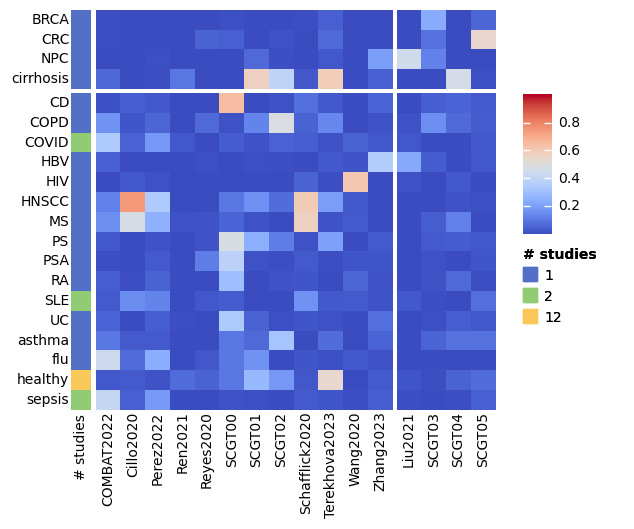

In [227]:
h = ma.Heatmap(correlation_matrix, vmin=0, vmax=1)
h.group_cols(study_No_healthy)

left_number = mp.Colors(diseaseXstudy.studyID.values, label = '# studies')
h.add_left(left_number, size=0.2, pad=0.05)

h.group_rows(disease.isin( disease_with_healthy))

h.add_bottom(mp.Labels(studyID))
h.add_left(mp.Labels(disease))

h.add_legends()

h.render()

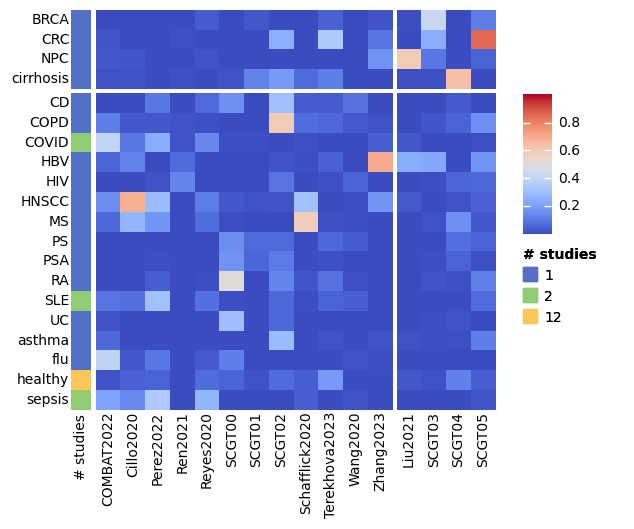

In [242]:
h = ma.Heatmap(correlation_matrix, vmin=0, vmax=1)
h.group_cols(study_No_healthy)

left_number = mp.Colors(diseaseXstudy.studyID.values, label = '# studies')
h.add_left(left_number, size=0.2, pad=0.05)

h.group_rows(disease.isin( disease_with_healthy))

h.add_bottom(mp.Labels(studyID))
h.add_left(mp.Labels(disease))

h.add_legends()

h.render()

In [10]:
np.unique(disease_mean_abs.argsort(axis=0)[-5:])

array([  9,  28,  37,  42,  48,  49,  54,  73,  75,  97, 109, 111, 120,
       137, 148, 156, 165, 170, 177, 179, 181, 195, 196, 198, 199, 205,
       207, 297, 324, 327, 351, 367, 411, 412, 419, 426, 431, 436, 471,
       481, 489, 509, 519, 524, 562, 582, 585, 588, 602, 607, 621, 626,
       636, 669, 673, 677, 682, 707, 718, 728, 756, 767, 778, 780, 784,
       788, 789, 790, 797, 798, 821, 823, 827, 840, 845, 855, 861, 862,
       868, 872, 876, 877, 882, 883, 891, 906, 907, 912, 915, 916])

In [11]:
filtered_genes_idx = np.setdiff1d(np.unique(disease_mean_abs.argsort(axis=0)[-10:]), np.unique(studyID_mean_abs.argsort(axis=0)[-10:]))
genes[filtered_genes_idx].tolist()

['MATK',
 'IL32',
 'BAK1',
 'MYOM2',
 'TNFRSF17',
 'YBX1',
 'TNFRSF1A',
 'NFKB2',
 'ITM2A',
 'ICAM1',
 'GLG1',
 'IL12RB1',
 'ATP5F1D',
 'TSPO',
 'IL2RB',
 'HCK',
 'DCTN6',
 'TLE5',
 'ITGB8',
 'CLDN15',
 'C1QBP',
 'SYNGR2',
 'CNTNAP1',
 'UNC93B1',
 'MS4A6A',
 'CCL20',
 'ID3',
 'SERP1',
 'PLBD1',
 'CSTA',
 'CD80',
 'CCRL2',
 'PTGER2',
 'TNFSF9',
 'IFI6',
 'IL22',
 'CCL25',
 'JCHAIN',
 'BEX2',
 'GLUL',
 'CTSV',
 'PIM1',
 'IFI44L',
 'CYP1B1',
 'IGSF6',
 'IFNAR1',
 'S100A8',
 'WTAP',
 'ESAM',
 'IL18',
 'JAM2',
 'NRG1',
 'IFNAR2',
 'HK3',
 'GFI1',
 'MNDA',
 'CXCL1',
 'CSF2',
 'IFI27',
 'FTH1',
 'SDC2',
 'CLIC3',
 'MZB1',
 'SOCS5',
 'BASP1',
 'GRB2',
 'EGR3',
 'MCEMP1',
 'CLDN5',
 'CSF1',
 'IL3RA',
 'SOCS1',
 'IFNLR1',
 'IFITM1',
 'NDUFA13',
 'LILRA5',
 'H4C3',
 'C5AR1',
 'CSF2RA',
 'HLA-E',
 'ADGRG1',
 'CRLF2',
 'IGHG4',
 'IGHG2',
 'IGHG3',
 'CRIP1',
 'TAPBP',
 'HLA-DQA2',
 'TNFRSF6B',
 'IL10RB',
 'NME2',
 'LYN']